In [ ]:
!pip install torch transformers
!pip install datasets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.5 MB/s eta 0:00:0

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig, TrainingArguments,Trainer,BertModel
from datasets import load_dataset, load_metric
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from datasets import load_dataset, load_metric

In [ ]:
# Modify the configuration
config = BertConfig.from_pretrained("bert-base-uncased")
config.num_hidden_layers = 6  
config.num_attention_heads = 6  

model = BertModel(config)

In [ ]:

import torch
from torch.utils.data import DataLoader
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer
from datasets import load_dataset
from transformers import BertTokenizer
from datasets import load_dataset, Dataset

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = load_dataset('glue', 'sst2')

subset_dataset = dataset['train'][:1000] 

train_dataset = Dataset.from_dict(subset_dataset)
train_dataset = train_dataset.map(lambda examples: {
    'input_ids': tokenizer(examples['sentence'], padding='max_length', truncation=True)['input_ids'],
    'labels': examples['label']
}, batched=True)

test_dataset = dataset['validation'].map(lambda examples: {
    'input_ids': tokenizer(examples['sentence'], padding='max_length', truncation=True)['input_ids'],
    'labels': examples['label']
}, batched=True)

train_dataset = dataset["train"]
eval_dataset = dataset["validation"]


config = BertConfig.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create the model architecture for sequence classification
'model = BertForSequenceClassification(config)'
config = BertConfig.from_pretrained("bert-base-uncased")
config.num_hidden_layers = 6  
config.num_attention_heads = 6  

model = BertModel(config)


train_encodings = tokenizer(train_dataset["sentence"], truncation=True, padding=True)
train_labels = train_dataset["label"]

# Prepare your training DataLoader
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings["input_ids"]),
    torch.tensor(train_encodings["attention_mask"]),
    torch.tensor(train_labels)
)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Fine-tune the model
model.train()
for epoch in range(3): 
    total_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} - Avg Loss: {total_loss/len(train_dataloader):.4f}")


eval_encodings = tokenizer(eval_dataset["sentence"], truncation=True, padding=True)
eval_labels = eval_dataset["label"]

eval_dataset = torch.utils.data.TensorDataset(
    torch.tensor(eval_encodings["input_ids"]),
    torch.tensor(eval_encodings["attention_mask"]),
    torch.tensor(eval_labels)
)
eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=False)

model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in eval_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted_labels = torch.max(outputs.logits, dim=1)

        total_correct += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print("Accuracy: {:.2%}".format(accuracy))


Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Epoch 1 - Avg Loss: 0.4690
Epoch 2 - Avg Loss: 0.2820
Epoch 3 - Avg Loss: 0.2319
Accuracy: 80.28%


In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = load_dataset('glue', 'sst2')

subset_dataset = dataset['train'][:1000] 

train_dataset = Dataset.from_dict(subset_dataset)
train_dataset = train_dataset.map(lambda examples: {
    'input_ids': tokenizer(examples['sentence'], padding='max_length', truncation=True)['input_ids'],
    'labels': examples['label']
}, batched=True)

test_dataset = dataset['validation'].map(lambda examples: {
    'input_ids': tokenizer(examples['sentence'], padding='max_length', truncation=True)['input_ids'],
    'labels': examples['label']
}, batched=True)

train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

config = BertConfig.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create the model architecture for sequence classification
model = BertForSequenceClassification(config)

train_encodings = tokenizer(train_dataset["sentence"], truncation=True, padding=True)
train_labels = train_dataset["label"]

# Prepare your training DataLoader
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings["input_ids"]),
    torch.tensor(train_encodings["attention_mask"]),
    torch.tensor(train_labels)
)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Initialize lists for loss and accuracy
train_losses = []
eval_accuracies = []

# Fine-tune the model
model.train()
for epoch in range(3): 
    total_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")

eval_encodings = tokenizer(eval_dataset["sentence"], truncation=True, padding=True)
eval_labels = eval_dataset["label"]

eval_dataset = torch.utils.data.TensorDataset(
    torch.tensor(eval_encodings["input_ids"]),
    torch.tensor(eval_encodings["attention_mask"]),
    torch.tensor(eval_labels)
)
eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=False)

model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in eval_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model


  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Epoch 1 - Avg Loss: 0.4673
Epoch 2 - Avg Loss: 0.2847
Epoch 3 - Avg Loss: 0.2303


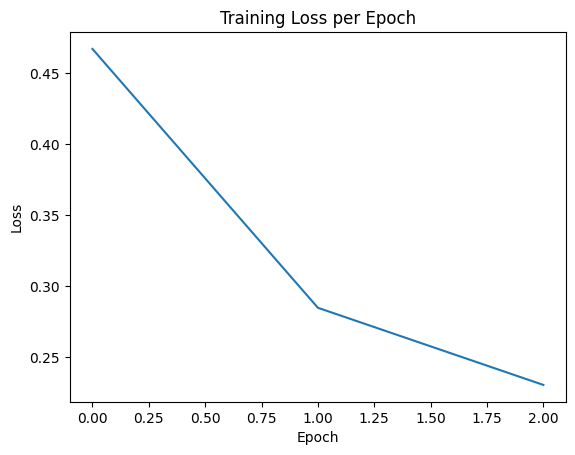

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.show()


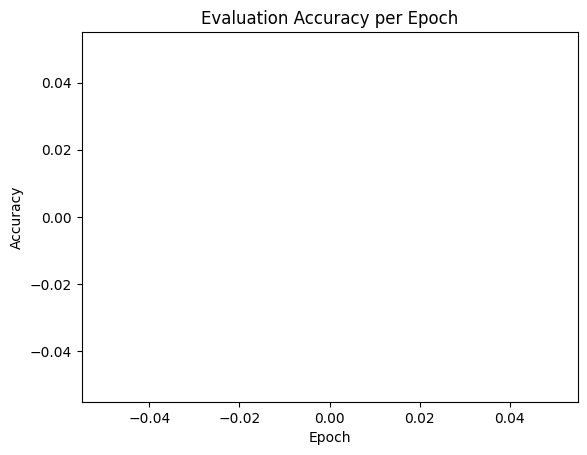

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eval_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy per Epoch')
plt.show()
